In [1]:
# Data source
# http://www.seanlahman.com/baseball-archive/statistics/
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
data = pd.read_csv("./data/Batting.csv")
display(data.head())
display(data.shape)

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
0,abercda01,1871,1,TRO,NaN,1,4,0,0,0,...,0.0,0.0,0.0,0,0.0,NaN,NaN,NaN,NaN,0.0
1,addybo01,1871,1,RC1,NaN,25,118,30,32,6,...,13.0,8.0,1.0,4,0.0,NaN,NaN,NaN,NaN,0.0
2,allisar01,1871,1,CL1,NaN,29,137,28,40,4,...,19.0,3.0,1.0,2,5.0,NaN,NaN,NaN,NaN,1.0
3,allisdo01,1871,1,WS3,NaN,27,133,28,44,10,...,27.0,1.0,1.0,0,2.0,NaN,NaN,NaN,NaN,0.0
4,ansonca01,1871,1,RC1,NaN,25,120,29,39,11,...,16.0,6.0,2.0,2,1.0,NaN,NaN,NaN,NaN,0.0


(107429, 22)

# Loading and cleaning data

In [2]:
# Assuming that
# AB = at bats
# H = hits
data_player = data[['playerID','AB','H']].groupby('playerID').agg({
    'AB':['count','sum'],
    'H':['sum']
})
display(data_player)

AB            H
          count    sum   sum
playerID                    
aardsda01     9      4     0
aaronha01    23  12364  3771
aaronto01     7    944   216
aasedo01     13      5     0
abadan01      3     21     2
...         ...    ...   ...
zupofr01      3     18     3
zuvelpa01     9    491   109
zuverge01    10    142    21
zwilldu01     4   1280   364
zychto01      3      0     0

[19689 rows x 3 columns]

In [3]:
data_player.columns=['count','ab','h']
data_player['avg'] = (data_player.h * 1.0)/ data_player.ab
data_player.head()

,count,ab,h,avg
playerID,,,,
aardsda01,9,4,0,0.000000
aaronha01,23,12364,3771,0.304998
aaronto01,7,944,216,0.228814
aasedo01,13,5,0,0.000000
abadan01,3,21,2,0.095238


In [4]:
tmp = data_player[data_player.avg >= 1.0]
print(len(tmp))
tmp.head()

95


,count,ab,h,avg
playerID,,,,
abramge01,1,1,1,1.0
alanirj01,2,1,1,1.0
alberan01,4,1,1,1.0
banisje01,1,1,1,1.0
bartocl01,2,1,1,1.0


In [5]:
# Drop certain observations
data_player = data_player.loc[(data_player.avg < 1.0) & (data_player.ab >= 50)]
data_player.shape

(10532, 4)

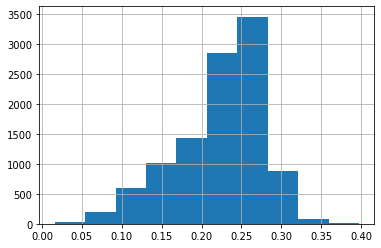

In [6]:
%matplotlib inline
data_player.avg.hist()

In [7]:
mean_emp = np.mean(data_player.avg)
mean_emp

0.2232326597703934

In [8]:
data_player.describe()

,count,ab,h,avg
count,10532.000000,10532.000000,10532.000000,10532.000000
mean,7.833840,1423.698063,373.060292,0.223233
std,5.296536,1963.200861,558.754524,0.054876
min,1.000000,50.000000,1.000000,0.015873
25%,3.000000,166.000000,31.000000,0.192308
50%,7.000000,511.000000,110.000000,0.236230
75%,11.000000,1855.500000,470.000000,0.262278
max,31.000000,14053.000000,4256.000000,0.397436


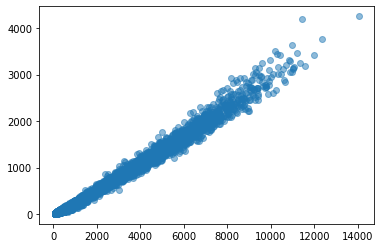

In [9]:
# There is some form of a linear relationship here
plt.scatter(x=data_player.ab, y = data_player.h, alpha=0.5)

# Fitting with a Beta prior

## Random draw from a Beta distribution

Text(0, 0.5, 'Frequency')

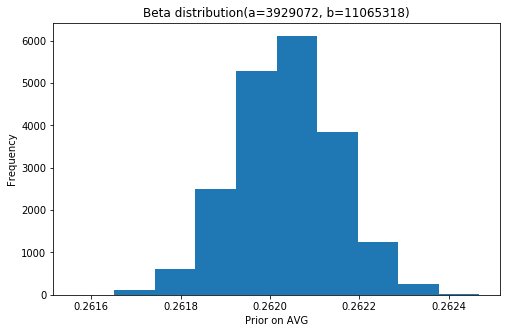

In [10]:
# Source: https://towardsdatascience.com/bayesball-bayesian-analysis-of-batting-average-102e0390c0e4
ds_prior_trials = data_player.ab.sum()
ds_prior_success = data_player.h.sum()

n_draw = 20000
prior_i_02 = pd.Series(np.random.beta(ds_prior_success+1, 
                                      ds_prior_trials-ds_prior_success+1, size = n_draw)) 
plt.figure(figsize=(8,5))
plt.hist(prior_i_02)
plt.title('Beta distribution(a=%d, b=%d)' % (ds_prior_success+1,ds_prior_trials-ds_prior_success+1))
plt.xlabel('Prior on AVG')
plt.ylabel('Frequency')

According to Wikipedia, the Beta distribution has 2 parameters $\alpha$ and $\beta$. 
The mean is $\frac{\alpha}{\alpha+\beta}$

so we can think of $\alpha$ = number of successes, $\beta$ = number of failures

In [11]:
data_player['n'] = data_player['h']
data_player['m'] = data_player['ab'] - data_player['h']
n, m = np.sum(data_player.n), np.sum(data_player.m)
print(n, m)

3929071 11065317


In [12]:
# Posterior prediction is the mode
data_player['avg_posterior'] = (data_player.n + n - 1)*1.0 / (data_player.n + data_player.m + n + m -2)
data_player.head()

,count,ab,h,avg,n,m,avg_posterior
playerID,,,,,,,
aaronha01,23,12364,3771,0.304998,3771,8593,0.262071
aaronto01,7,944,216,0.228814,216,728,0.262034
abbated01,10,3044,772,0.253614,772,2272,0.262034
abbeybe01,6,225,38,0.168889,38,187,0.262035
abbeych01,5,1756,493,0.280752,493,1263,0.262038


## difference between empirical and posterior
for some observations, this difference is quite large

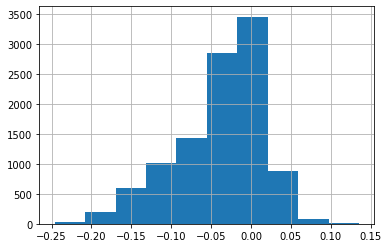

In [13]:
data_player['diff'] = data_player.avg - data_player.avg_posterior
data_player['diff'].hist()

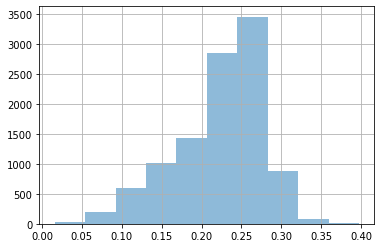

In [14]:
# TODO: find a way to combine the two graphs
fig, ax = plt.subplots()
_ = data_player['avg'].hist(ax=ax, label='emp',alpha=0.5)

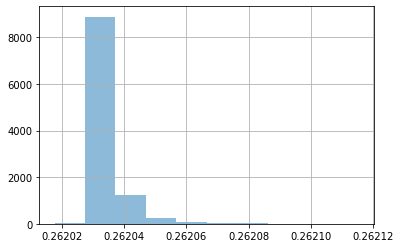

In [15]:
# All the values concentrated around 0.26
fig, ax = plt.subplots()
ax = data_player['avg_posterior'].hist(ax=ax, label='emp',alpha=0.5)

My alpha and beta parameters are too large so they concentrate the prior distribution around that particular spot

## Testing for better alpha and beta
without much understanding of Bayesian statistics, suppose that I want to choose alpha and better to minimize RMSE between actual and posterior values, what should be the best alpha and better?

In [16]:
def cost_function_int(x, data):
    alpha, beta=int(x[0]),int(x[1])
    post = (data.n + alpha - 1)*1.0 / (data.n + data.m + alpha + beta -2)
    return np.sqrt(np.mean((post-data.avg)**2))

cost_function_int([n, m], data_player)


0.06720553759550231

### scipy minimize does not take the functions well and cannot minimize it

In [17]:
from scipy.optimize import minimize
res = minimize(cost_function_int, [1000, 2000], args=(data_player))
res

      fun: 0.10902552347769574
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([1000., 2000.])

### What if I drop the integer

In [18]:
def cost_function(x, data):
    alpha, beta=x[0], x[1]
    post = (data.n + alpha - 1)*1.0 / (data.n + data.m + alpha + beta -2)
    return np.sqrt(np.mean((post-data.avg)**2))

cost_function([2.5, 5.6], data_player)

0.0031423314319718528

In [19]:
res = minimize(cost_function, [100, 200], args=(data_player))
res

      fun: 1.2622317142783098e-10
 hess_inv: array([[3.37551233e-05, 1.33198562e-04],
       [1.33198562e-04, 7.05627743e-04]])
      jac: array([-5.92273334e-06,  3.10325926e-07])
  message: 'Optimization terminated successfully.'
     nfev: 408
      nit: 59
     njev: 102
   status: 0
  success: True
        x: array([0.99999994, 0.99999975])

The best results is just assume $n = m = 1$

# The better way to do 
Source: https://docs.pymc.io/notebooks/hierarchical_partial_pooling.html

This has to do with the way to pick $\alpha$ and $\beta$. The beta distribution can be specified by:
- Shape: $\alpha$ and $\beta$
- Mean (based on $\alpha$ and $\beta$) and sample size(proxy for variance) $v = \alpha + \beta$

The article suggests the 2nd approach:
- $\phi$: related to the expected performance for all players  -> uniform
- $\kappa$: the variance of batting average -> Pareto distribution. However, it is more efficient to pick the <b>log of $\kappa$ </b> as an <i>exponential distribution </i>, which has large tail



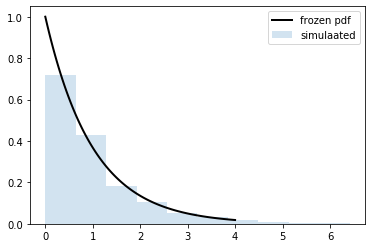

In [28]:
## Let's the pdf of an exponential distribution
from scipy.stats import expon

fig, ax = plt.subplots()

rv = expon(scale=1)
x = np.linspace(0,4, 100)

# generate random values

ax.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')

r = rv.rvs(size=1000)
_ = ax.hist(r, density=True, histtype='stepfilled', alpha=0.2, label='simulaated')
ax.legend(loc='best')
plt.show()

(array([1.60955297e-02, 1.63905598e-04, 4.91716793e-05, 1.63905598e-05,
        1.63905598e-05, 1.63905598e-05, 0.00000000e+00, 0.00000000e+00,
        1.63905598e-05, 1.63905598e-05]),
 array([  1.00101316,  62.01174216, 123.02247117, 184.03320017,
        245.04392918, 306.05465818, 367.06538718, 428.07611619,
        489.08684519, 550.0975742 , 611.1083032 ]),
 <a list of 1 Patch objects>)

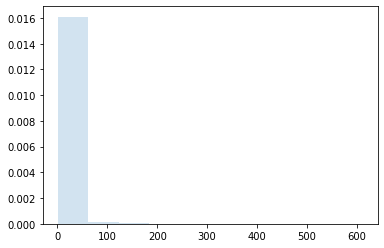

In [30]:
fig, ax = plt.subplots()

r_exp = np.exp(r)
ax.hist(r_exp, density=True, histtype='stepfilled', alpha=0.2, 
        label='exponential')

Exponentiating it makes the difference a lot more severe. While the majority of the values are less than 100, we have a few values all the way up to 600.

In [32]:
print(len(r_exp),np.sum(r_exp >= 100))

1000 9
